In [99]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import random

# Set seed global untuk reproducibility
seed = 7
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Path dataset
dataset_dir = 'D:\\Semester 6\\AI\\Artificial_Inteligence\\PlantVillage'

In [100]:
# Parameter
batch_size = 16
img_size = (128, 128)

# Load data (resize otomatis)
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',
    shuffle=True,
    seed=seed  
)

# Ambil data dan label numpy
data, labels = [], []
for img_batch, label_batch in full_dataset:
    data.append(img_batch.numpy())
    labels.append(label_batch.numpy())
data = np.concatenate(data)
labels = np.concatenate(labels)

Found 2152 files belonging to 3 classes.


In [101]:
# Normalisasi data pixel dari [0,255] ke [0,1]
data = data / 255.0
data

array([[[[0.44705883, 0.4       , 0.4392157 ],
         [0.3764706 , 0.32941177, 0.36862746],
         [0.4       , 0.3529412 , 0.39215687],
         ...,
         [0.672549  , 0.6490196 , 0.6882353 ],
         [0.6745098 , 0.6509804 , 0.6901961 ],
         [0.68235296, 0.65882355, 0.69803923]],

        [[0.44607842, 0.3990196 , 0.43823528],
         [0.4137255 , 0.36666667, 0.40588236],
         [0.3882353 , 0.34117648, 0.38039216],
         ...,
         [0.66862744, 0.64509803, 0.6843137 ],
         [0.67156863, 0.6480392 , 0.6872549 ],
         [0.6754902 , 0.6519608 , 0.6911765 ]],

        [[0.45294118, 0.40588236, 0.44509804],
         [0.42647058, 0.37941176, 0.41862744],
         [0.38039216, 0.33333334, 0.37254903],
         ...,
         [0.6745098 , 0.6509804 , 0.6901961 ],
         [0.672549  , 0.6490196 , 0.6882353 ],
         [0.6745098 , 0.6509804 , 0.6901961 ]],

        ...,

        [[0.46078432, 0.42941177, 0.5117647 ],
         [0.4627451 , 0.43137255, 0.5137255 ]

In [102]:
# Split data jadi train 80%, val 10%, test 10%
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2, random_state=seed, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, shuffle=True)

In [103]:
# Buat fungsi augmentasi sederhana (flip horizontal)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

# Buat tf.data.Dataset untuk train, val, test
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000, seed=seed).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Terapkan augmentasi hanya ke train dataset
train_dataset = train_dataset.map(augment)

In [104]:
# Prefetch untuk performa
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [105]:

# Flatten data gambar (dari 128x128x3 ke 49152 fitur)
def flatten_image(image, label):
    image = tf.reshape(image, (-1, 128*128*3))  # flatten setiap batch
    return image, label

train_dataset_flat = train_dataset.map(flatten_image)
val_dataset_flat = val_dataset.map(flatten_image)
test_dataset_flat = test_dataset.map(flatten_image)

In [106]:
# Definisikan model ANN
input_dim = 128 * 128 * 3  # 49152

model_ann = models.Sequential([
    layers.InputLayer(input_shape=(input_dim,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [107]:
# Compile model
model_ann.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_ann.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,624,515 (48.16 MB)

 Trainable params: 12,624,515 (48.16 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
# Training model dengan validation data
epochs = 10
history_ann = model_ann.fit(
    train_dataset_flat,
    validation_data=val_dataset_flat,
    epochs=epochs
)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.8151 - loss: 0.4422 - val_accuracy: 0.8651 - val_loss: 0.3587
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.8820 - loss: 0.3153 - val_accuracy: 0.7070 - val_loss: 0.7445
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.8182 - loss: 0.4534 - val_accuracy: 0.8698 - val_loss: 0.3868
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.8282 - loss: 0.4093 - val_accuracy: 0.8047 - val_loss: 0.4633
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.8612 - loss: 0.3760 - val_accuracy: 0.8977 - val_loss: 0.2708
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.8608 - loss: 0.3379 - val_accuracy: 0.9070 - val_loss: 0.2850
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.8789 - loss: 0.3181 - val_accuracy: 0.8884 - val_loss: 0.2760
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.8837 - loss: 0.3062 

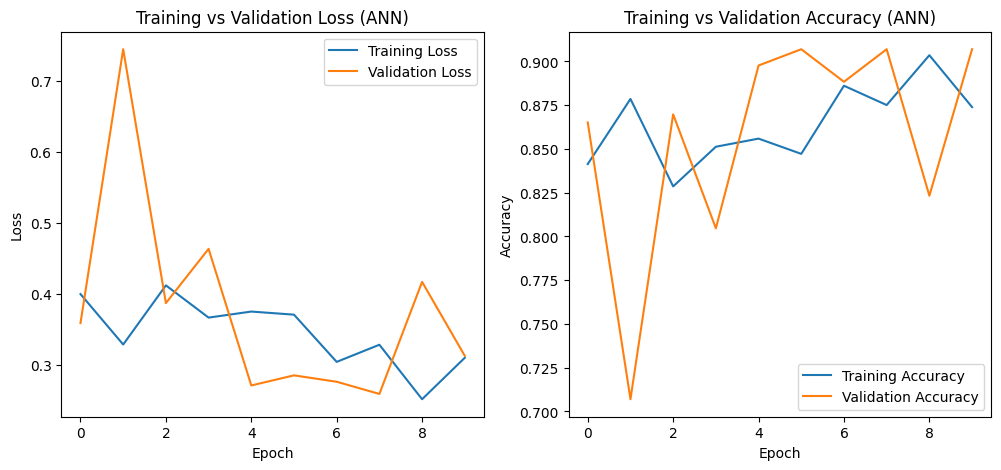

In [119]:
import matplotlib.pyplot as plt

# Plot loss dan accuracy dari model ANN
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_ann.history['loss'], label='Training Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (ANN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_ann.history['accuracy'], label='Training Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (ANN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [124]:
# Evaluasi model dengan test dataset
test_loss, test_accuracy = model_ann.evaluate(test_dataset_flat)
print(f"Test accuracy ANN: {test_accuracy:.4f}")
print(f"Test loss ANN: {test_loss:.4f}")

 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9375 - loss: 0.3686

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9055 - loss: 0.3243
Test accuracy ANN: 0.8750
Test loss ANN: 0.3277


In [126]:
def predict_image_with_display_ann(image_path, model, img_size=(128, 128)):
    # Load dan resize gambar
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)  # shape (128,128,3)
    
    # Normalisasi pixel ke [0,1]
    img_array = img_array / 255.0
    
    # Flatten gambar ke 1D (49152,)
    img_flat = img_array.reshape(1, -1)  # batch size 1
    
    # Prediksi menggunakan model ANN
    predictions = model.predict(img_flat)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    
    # Tampilkan gambar dan prediksi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {class_names[predicted_class]}\nConfidence: {confidence*100:.2f}%")
    plt.show()
    
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


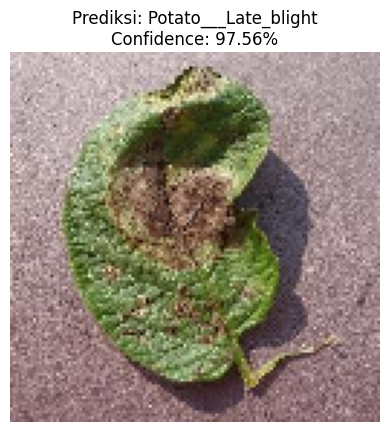

In [127]:
predicted_class, confidence = predict_image_with_display_ann('D:\\Semester 6\\AI\\Artificial_Inteligence\\new_images\\Late_blight2.jpg', model_ann)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


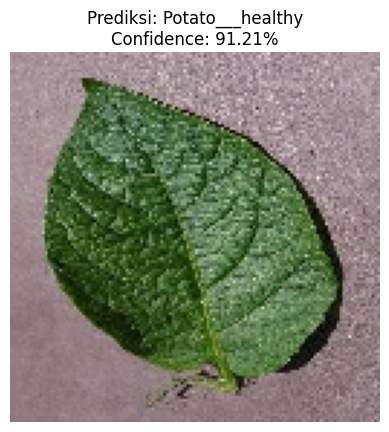

In [128]:
predicted_class, confidence = predict_image_with_display_ann('D:\\Semester 6\\AI\\Artificial_Inteligence\\new_images\\healthy2.jpg', model_ann)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


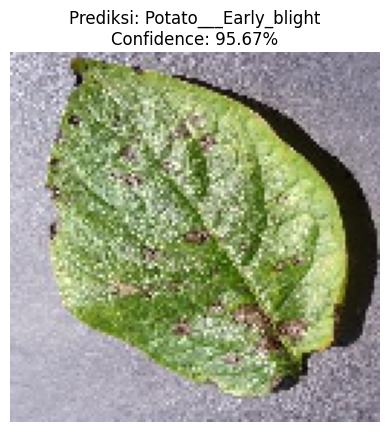

In [129]:
predicted_class, confidence = predict_image_with_display_ann('D:\\Semester 6\\AI\\Artificial_Inteligence\\new_images\\Early_blight.jpg', model_ann)